# Data

Data used for this demo can be downloaded from Kaggle: [link](https://www.kaggle.com/c/favorita-grocery-sales-forecasting/data)

It is 3 years daily sales data for a retailer, but we will be aggregating to monthly sales for this activity. 

I have tried to implement STL decomposition from scratch to propose an anomaly detection algorithm using only the residuals from the decomposition. We will be using a rolling median based technique to be add more robustness against outliers. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
# creating a new dataframe for total unit sales from dash dataframe
# chunksize = 10 ** 7
# df = pd.DataFrame()
# for chunk in pd.read_csv('train.csv', chunksize=chunksize):
#     # grouping data to find the total unit sales per day
#     data = chunk.groupby(['date'])['date', 'unit_sales'].sum()
#     df = df.append(data)
# df.head()

In [3]:
# df.reset_index(inplace=True)
# df = df.groupby('date')['date', 'unit_sales'].sum()
# df.reset_index(inplace=True)
# converting the date dtype from object to datetime
# df['date'] = pd.to_datetime(df['date']) 
# df.to_csv("sales_data_daily.csv", index=False)

In [4]:
df = pd.read_csv("sales_data_daily.csv")
df["date"] = pd.to_datetime(df["date"])
metric = "unit_sales"

In [5]:
## Plot function

def simple_plot(x, y, title="", x_label="", y_label="", figsize=(30, 10)):
    plt.figure(figsize=figsize)
    plt.rcParams.update({'font.size': 22})
    plt.grid()
    plt.plot(x, y, marker='', linestyle='-')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

/Users/siddheshpisal/.pyenv/versions/3.6.7/envs/notebook/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


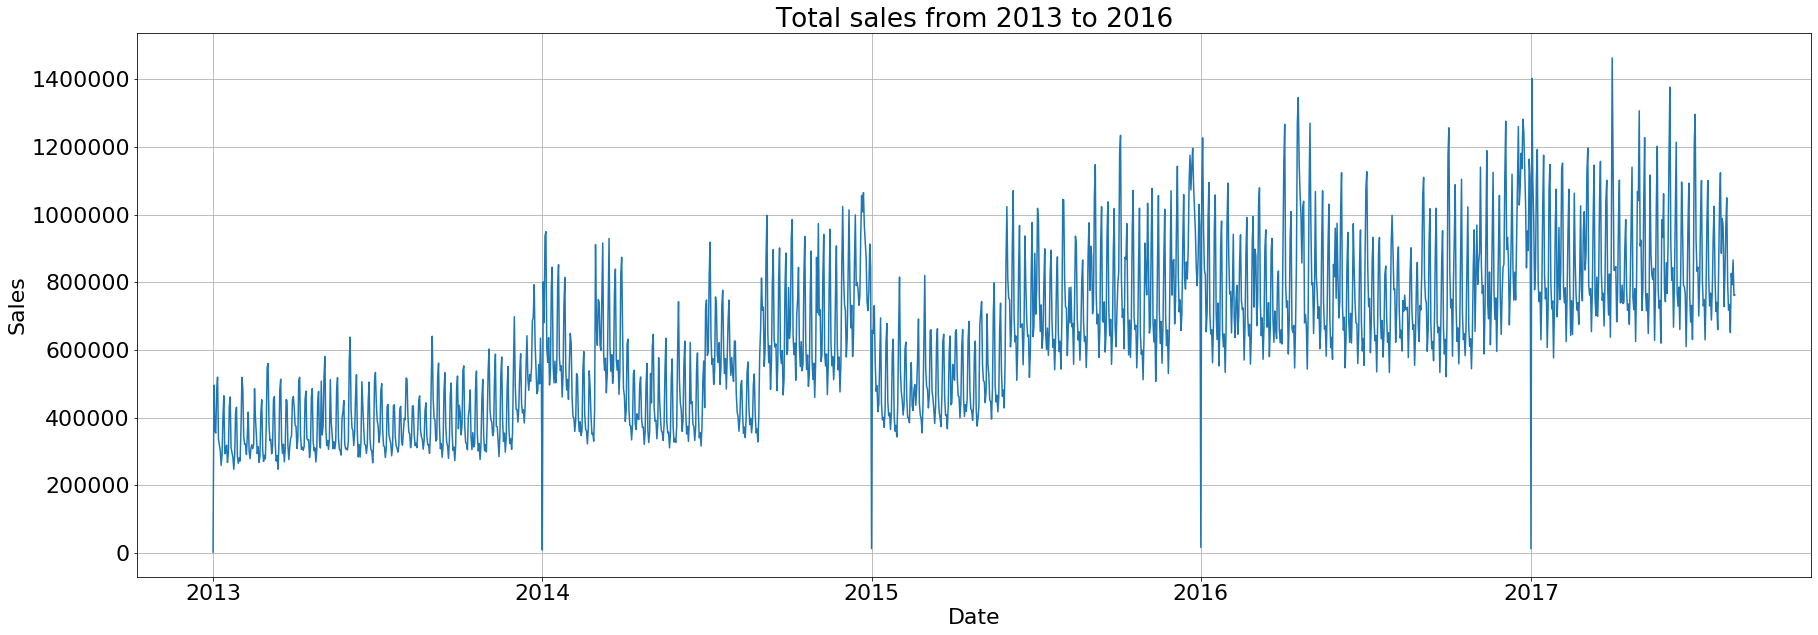

In [6]:
simple_plot(df["date"], df[metric], "Total sales from 2013 to 2016", "Date", "Sales")

In [7]:
data = df[(df.date.astype(str) >= '2013-01-01') & (df.date.astype(str) < '2018-01-01')].reset_index(drop=True)
# # splitting the date column to day, month and year
data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
# # grouping the data to find the total unit sales per month
data = data.groupby(['month', 'year', "day"])['date', 'unit_sales'].sum().sort_values(by=['year','month']).reset_index()
data.rename(columns={metric:'timeseries'}, inplace=True)
df


,date,unit_sales
0,2013-01-01,2511.619
1,2013-01-02,496092.418
2,2013-01-03,361429.231
3,2013-01-04,354459.677
4,2013-01-05,477350.121
...,...,...
1679,2017-08-11,826373.722
1680,2017-08-12,792630.535
1681,2017-08-13,865639.677
1682,2017-08-14,760922.406


In [8]:

def main_line_plot(x, y, title="", x_label="", y_label="", figsize=(30, 10)):
    plt.figure(figsize=figsize)
    plt.rcParams.update({'font.size': 22})
    plt.grid()
    if isinstance(y, list):
        for col in y:
            plt.plot(x, col, marker='', linestyle='-', label=col.name, linewidth=4)
    else:
        plt.plot(x, y, marker='', linestyle='-', label=y.name, linewidth=4)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()
    


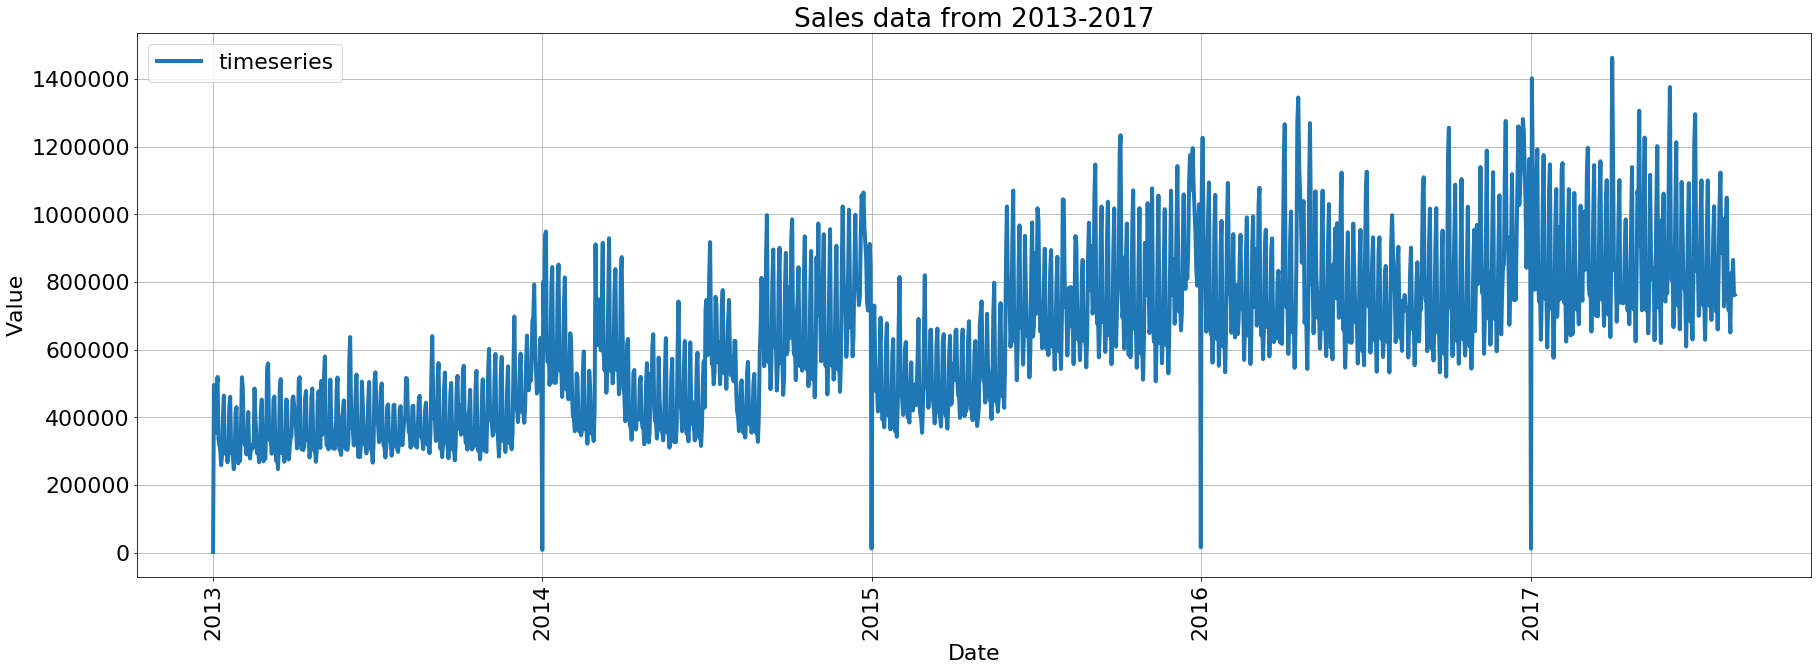

In [9]:
X_index = df["date"]

main_line_plot(X_index, data.timeseries, "Sales data from 2013-2017", "Date", "Value")

In [10]:
# importing libraries
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler


In [11]:

# index
X = data.index.values
# timeseries value
y = data.timeseries.values

In [12]:
# scaling
scaler = MinMaxScaler()
scaler = scaler.fit(y.reshape(-1,1))
y_scaled = scaler.transform(y.reshape(-1,1))


In [13]:

# creating polynomial feature of degree 5
poly = PolynomialFeatures(5)
X_poly = poly.fit_transform(X.reshape(-1,1))


In [14]:

# fitting model
model = LinearRegression()
model = model.fit(X_poly, y_scaled)

# approx_trend 
approx_trend = model.predict(X_poly)
data['approx_trend'] = scaler.inverse_transform(approx_trend)


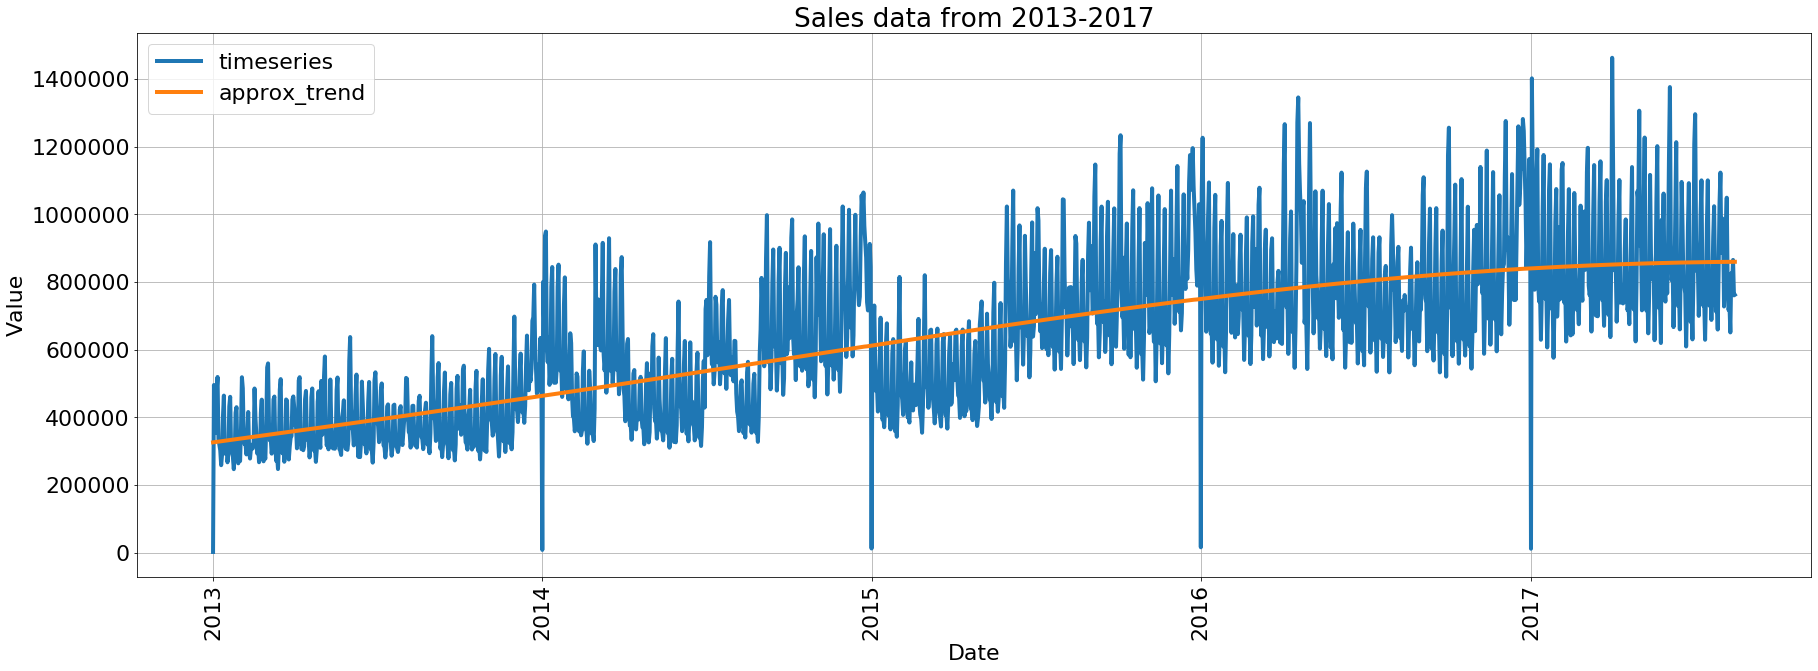

In [15]:
main_line_plot(X_index, [pd.Series(y, name="timeseries"), data.approx_trend], "Sales data from 2013-2017", "Date", "Value")


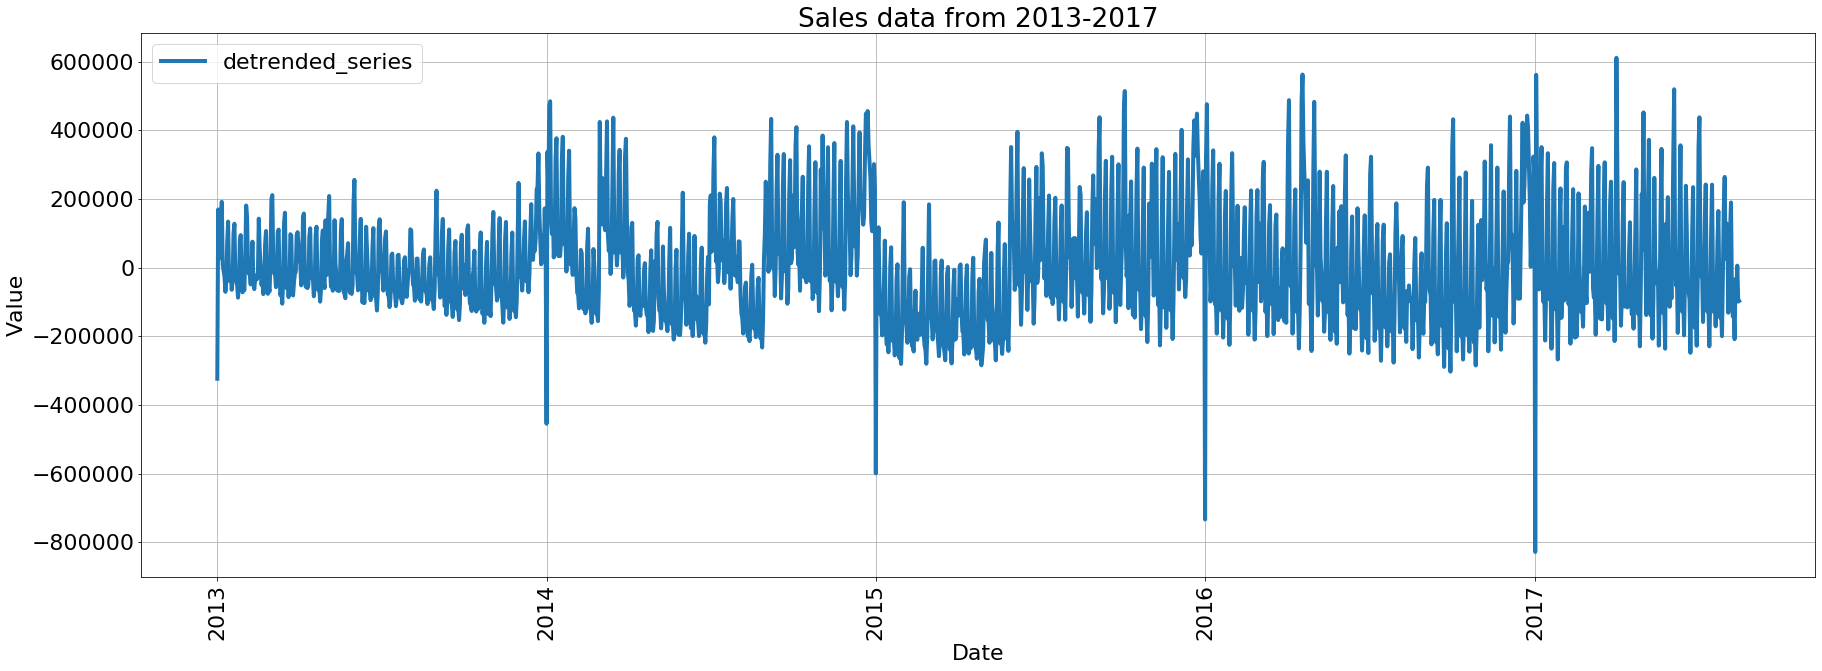

In [16]:
# Remove the trend after fitting linear model
data['detrended_series'] = data.timeseries - data.approx_trend.values

main_line_plot(X_index, data['detrended_series'], "Sales data from 2013-2017", "Date", "Value")


In [17]:
# find the seasonal pattern
seasonal_comp = data.groupby('day')['day', 'detrended_series'].mean().reset_index(drop=True)

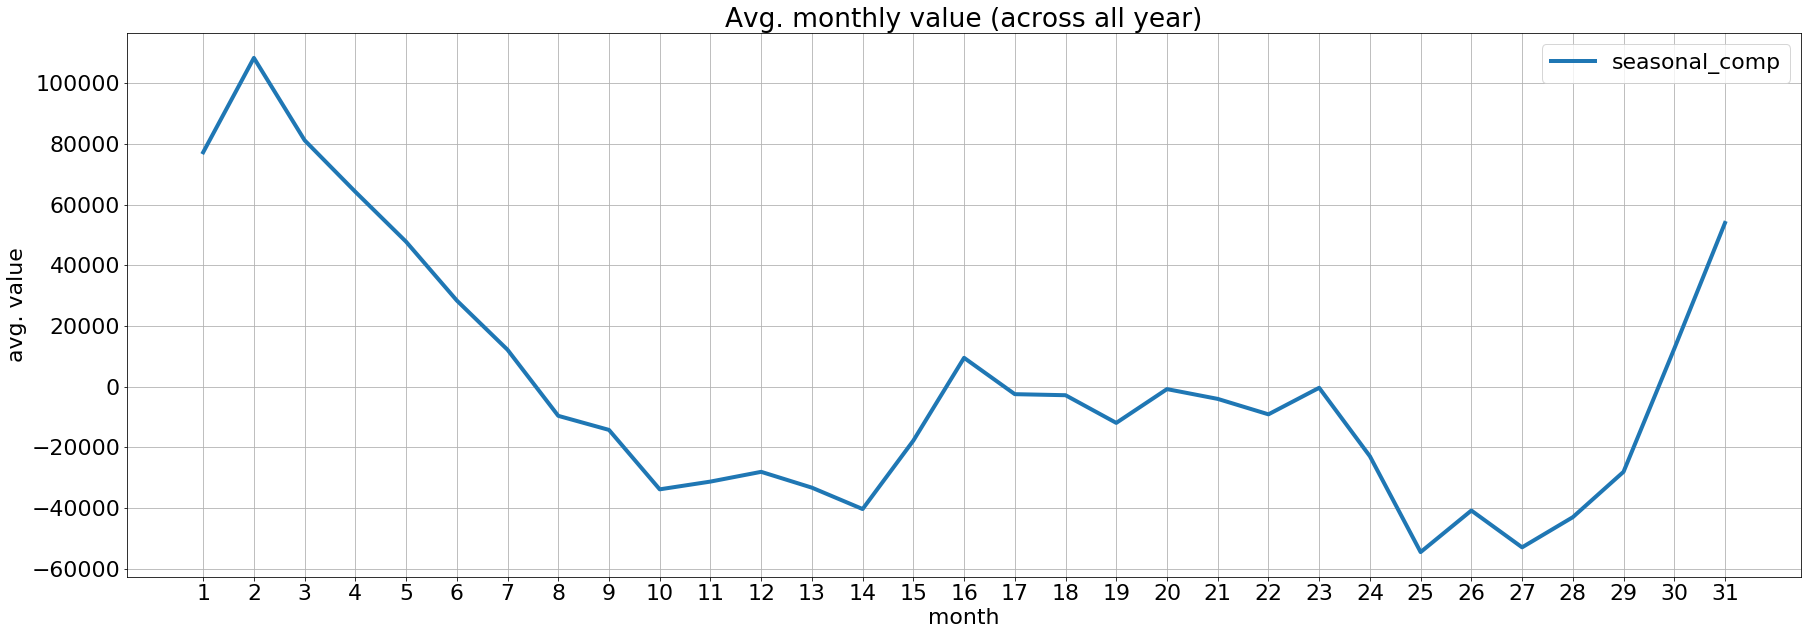

In [18]:

plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(seasonal_comp.day.astype(str), seasonal_comp.detrended_series, marker='', linestyle='-', label='seasonal_comp', linewidth=4)
plt.title("Avg. monthly value (across all year)")
plt.xlabel("month")
plt.ylabel("avg. value")
plt.legend()
plt.show()

In [19]:
# replicate this seasonal component across the timeseries
seasonal = pd.DataFrame()
if data.timeseries.shape[0]%seasonal_comp.shape[0] != 0:
    diff = data.timeseries.shape[0]%seasonal_comp.shape[0]
    for i in range(int(data.timeseries.shape[0]/seasonal_comp.shape[0])):
        seasonal = pd.concat([seasonal, seasonal_comp])
    seasonal = pd.concat([seasonal, seasonal_comp[:diff]])

data['seasonal'] = seasonal.detrended_series.values

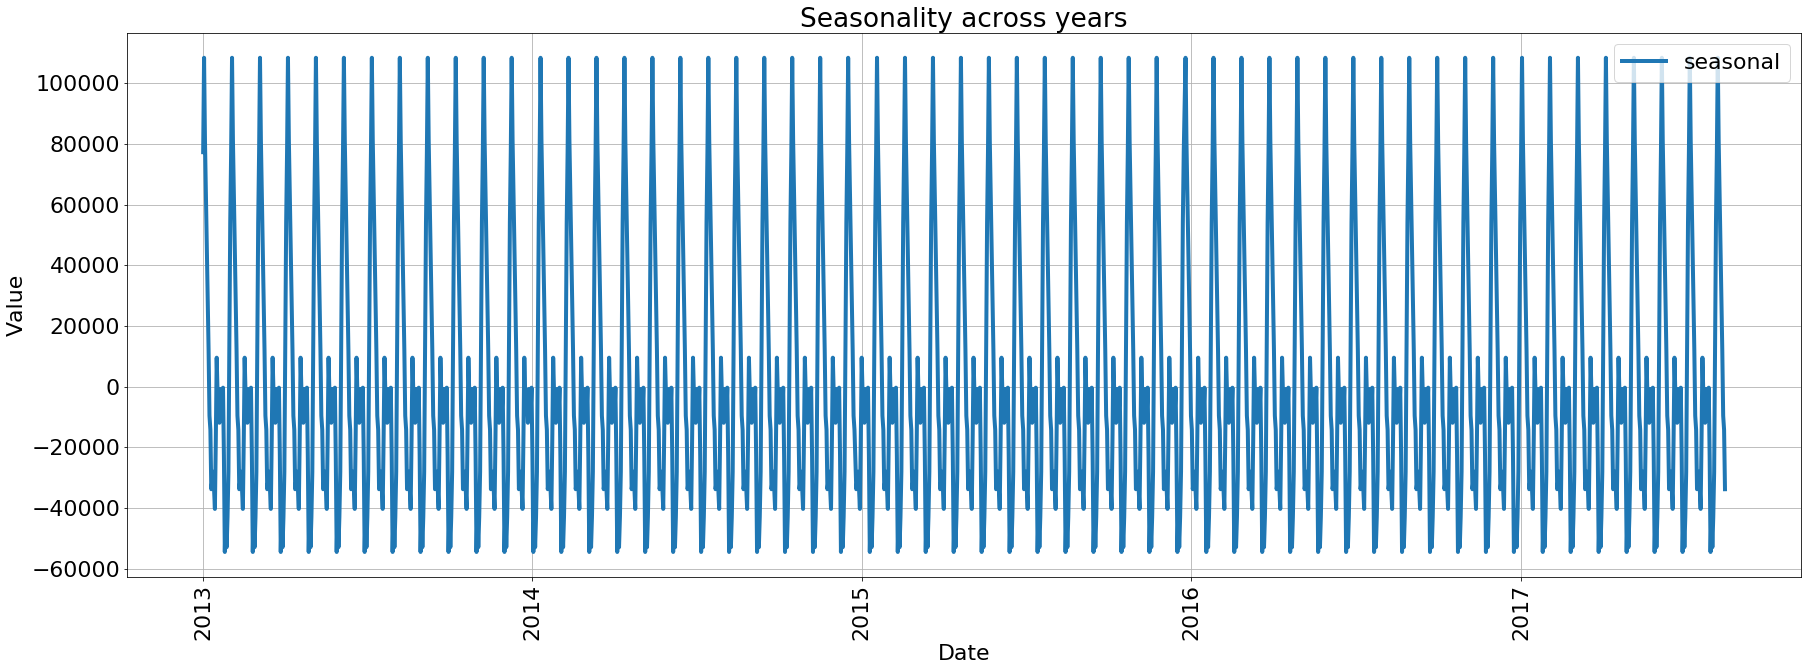

In [20]:
main_line_plot(X_index, data['seasonal'], "Seasonality across years", "Date", "Value")


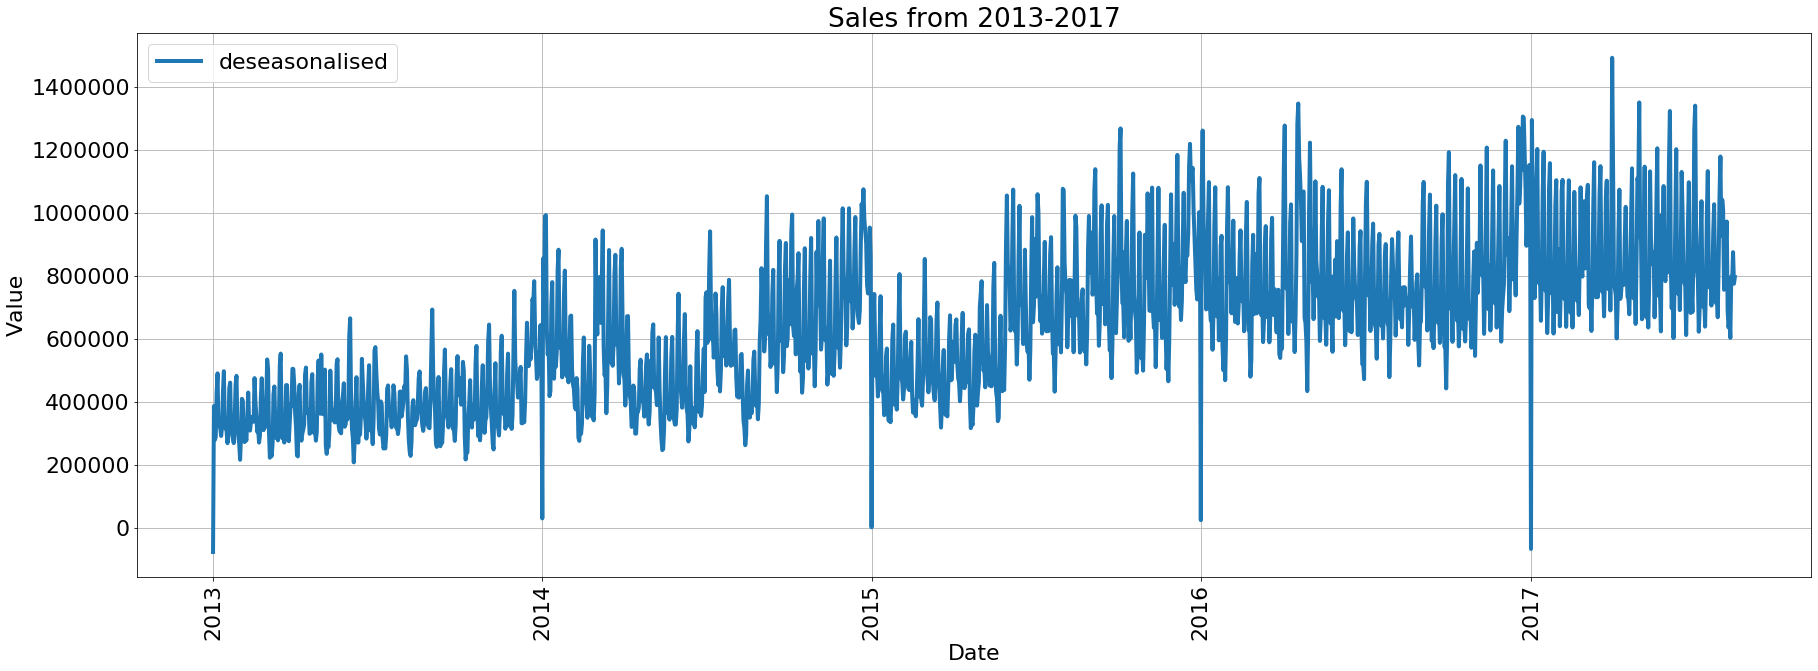

In [21]:
# Deseasonalize
data['deseasonalised'] = data.timeseries - data.seasonal

main_line_plot(X_index, data['deseasonalised'], "Sales from 2013-2017", "Date", "Value")


In [22]:
# fitting the polynomial model with deseasonalised data
scaler = MinMaxScaler()
scaler = scaler.fit(y.reshape(-1,1))
y_scaled = scaler.transform(data.deseasonalised.values.reshape(-1,1))

model = LinearRegression()
model = model.fit(X_poly, y_scaled)

# trend
trend = model.predict(X_poly)
data['trend'] = scaler.inverse_transform(trend)


In [47]:
data["exp_trend"] = data["timeseries"].ewm(span=365, adjust=False).mean()

main_line_plot(X_index, [data['trend'], data["exp_trend"], pd.Series(decomp.trend, name="stl_trend")], "Sales from 2013-2017", "Date", "Value")


,month,year,day,timeseries,approx_trend,detrended_series,seasonal,deseasonalised,trend,residual,rolling_median,rolling_std,outliers,outlier_val,exp_trend
0,1,2013,1,2511.619,326438.139767,-323926.520767,77270.195418,-74758.576418,322032.928007,-396791.504425,NaN,NaN,0,None,2511.619000
1,1,2013,2,496092.418,326803.218957,169289.199043,108384.551158,387707.866842,322433.960991,65273.905852,NaN,NaN,0,None,5208.781836
2,1,2013,3,361429.231,327168.286764,34260.944236,81236.872724,280192.358276,322834.788117,-42642.429841,NaN,NaN,0,None,7155.341668
3,1,2013,4,354459.677,327533.344139,26926.332861,64255.104851,290204.572149,323235.410980,-33030.838831,NaN,NaN,0,None,9053.179566
4,1,2013,5,477350.121,327898.392029,149451.728971,47804.947239,429545.173761,323635.831167,105909.342594,NaN,NaN,0,None,11612.179246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679,8,2017,11,826373.722,860050.323657,-33676.601657,28430.079387,797943.642613,857345.996366,-59402.353752,-45395.799802,155529.175856,0,None,839243.438958
1680,8,2017,12,792630.535,860073.033855,-67442.498855,12193.310684,780437.224316,857351.801921,-76914.577605,-45395.799802,151267.406944,0,None,838988.723635
1681,8,2017,13,865639.677,860095.175708,5544.501292,-9585.678341,875225.355341,857356.979462,17868.375879,-35348.843275,150811.366119,0,None,839134.357260
1682,8,2017,14,760922.406,860116.749557,-99194.343557,-14224.774165,775147.180165,857361.529291,-82214.349126,-45395.799802,148564.888741,0,None,838706.969548


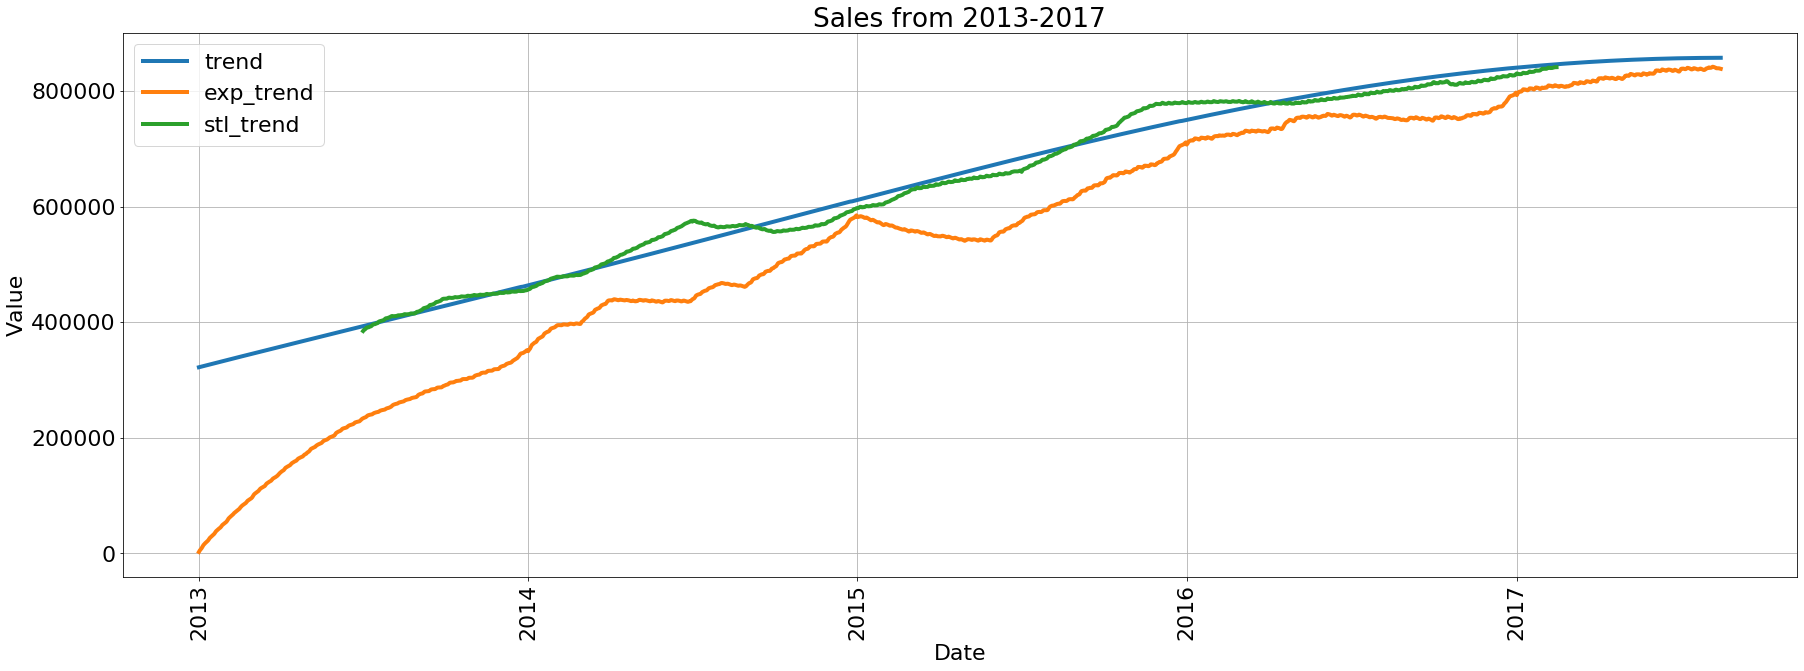

In [51]:
main_line_plot(X_index, [data['trend'], data["exp_trend"], pd.Series(decomp.trend, name="stl_trend")], "Sales from 2013-2017", "Date", "Value")


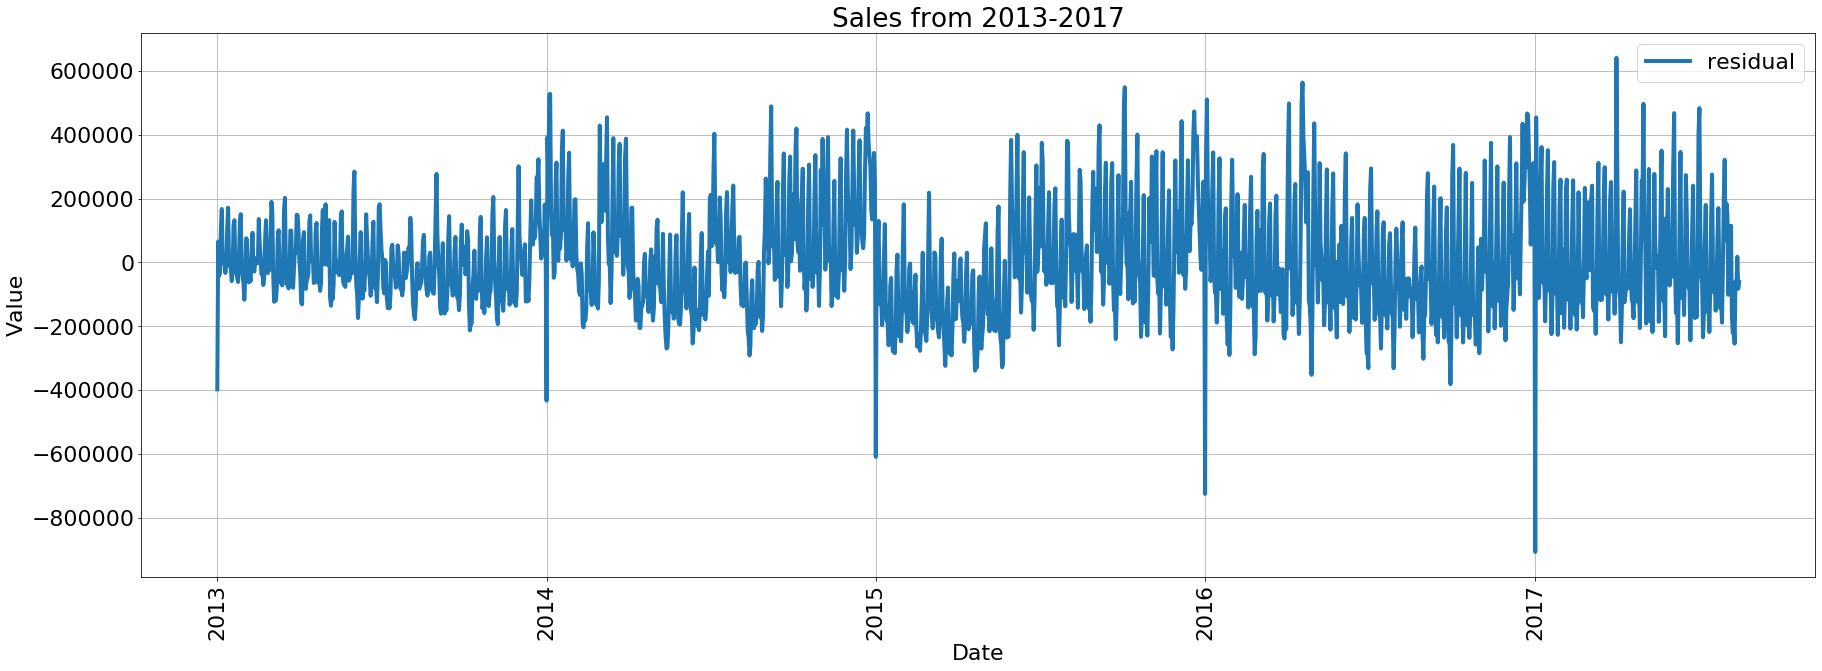

In [24]:
# Find the residual
data['residual'] = data.timeseries - data.trend - data.seasonal

main_line_plot(X_index, data['residual'], "Sales from 2013-2017", "Date", "Value")


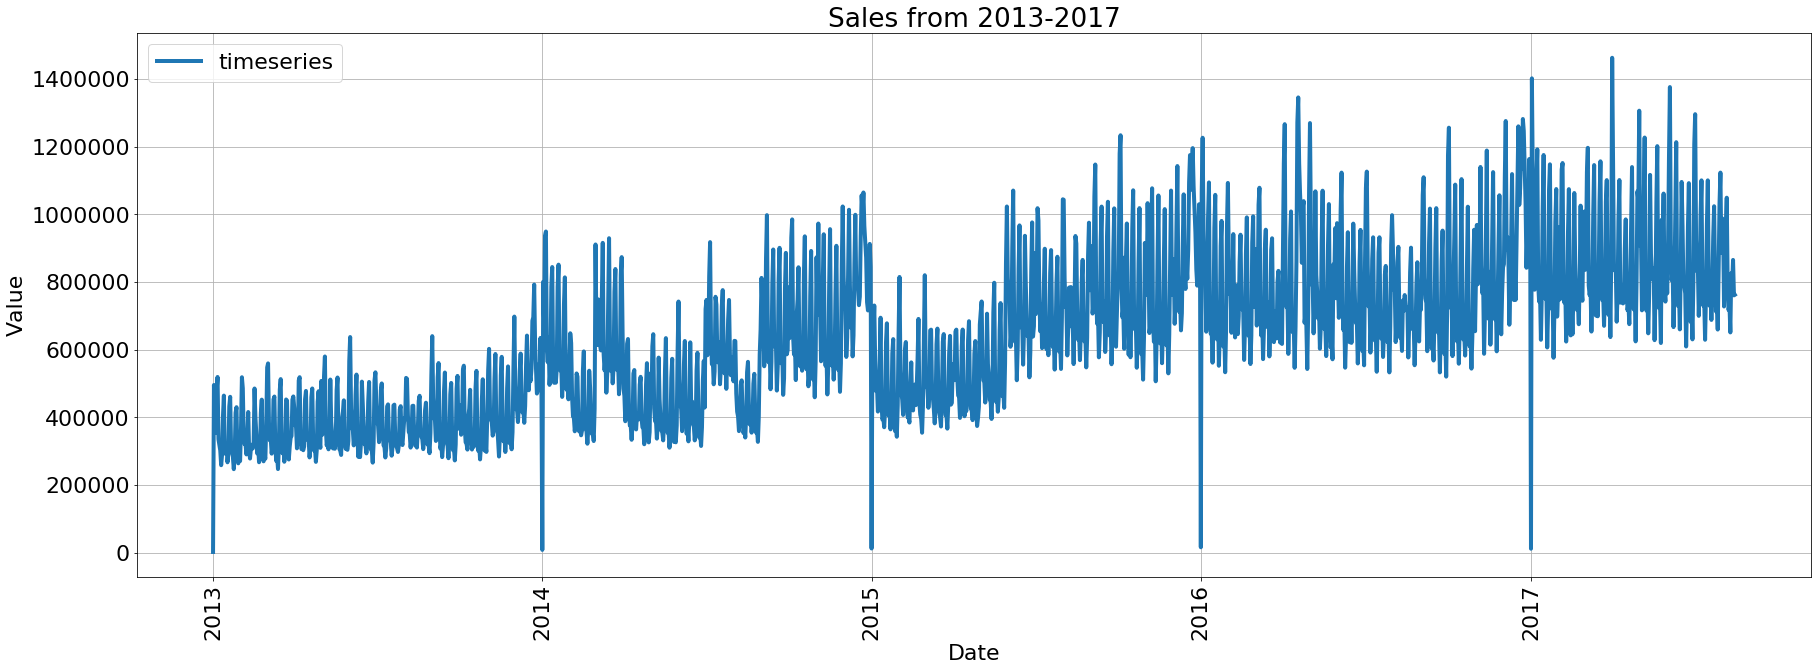

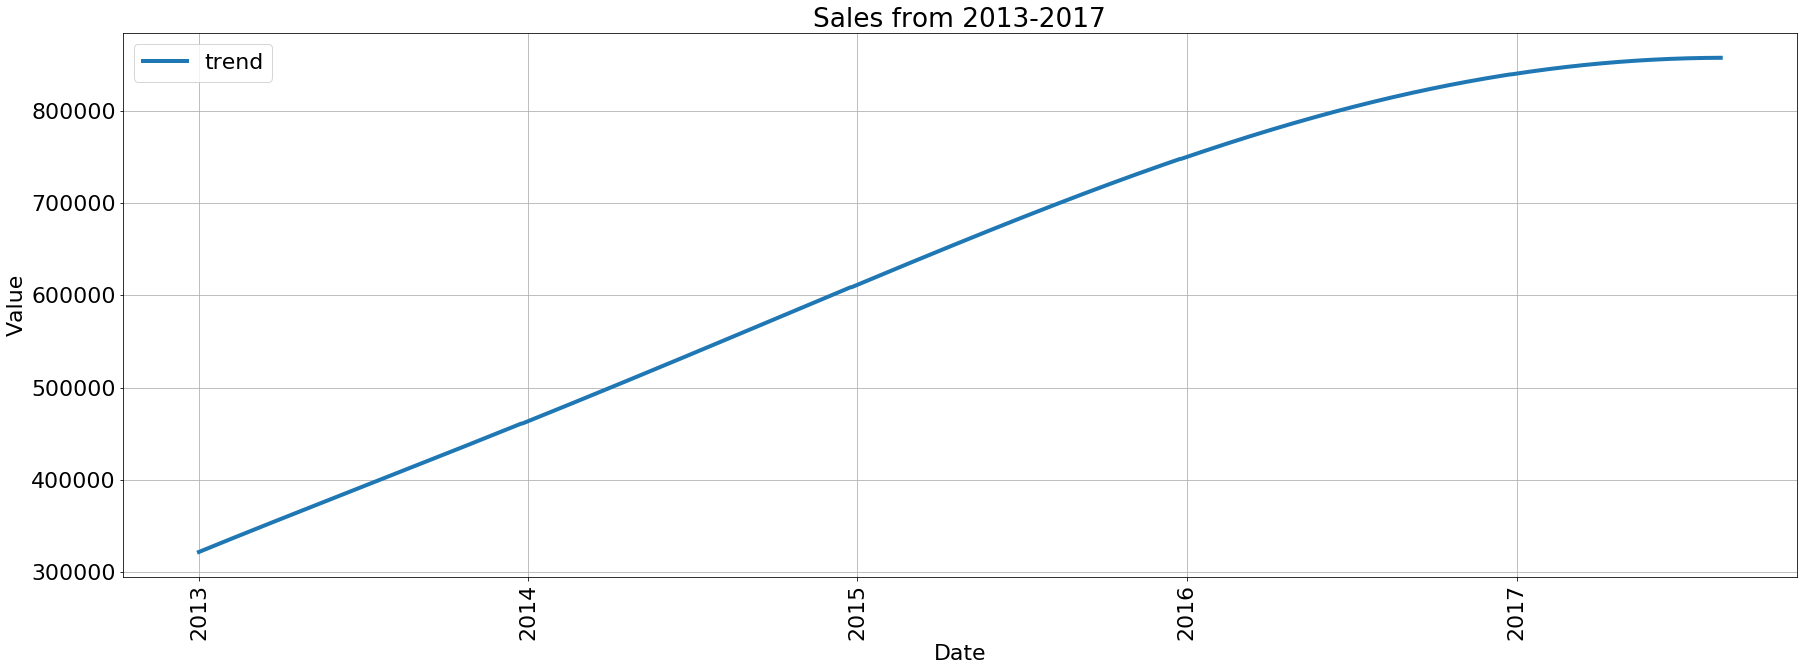

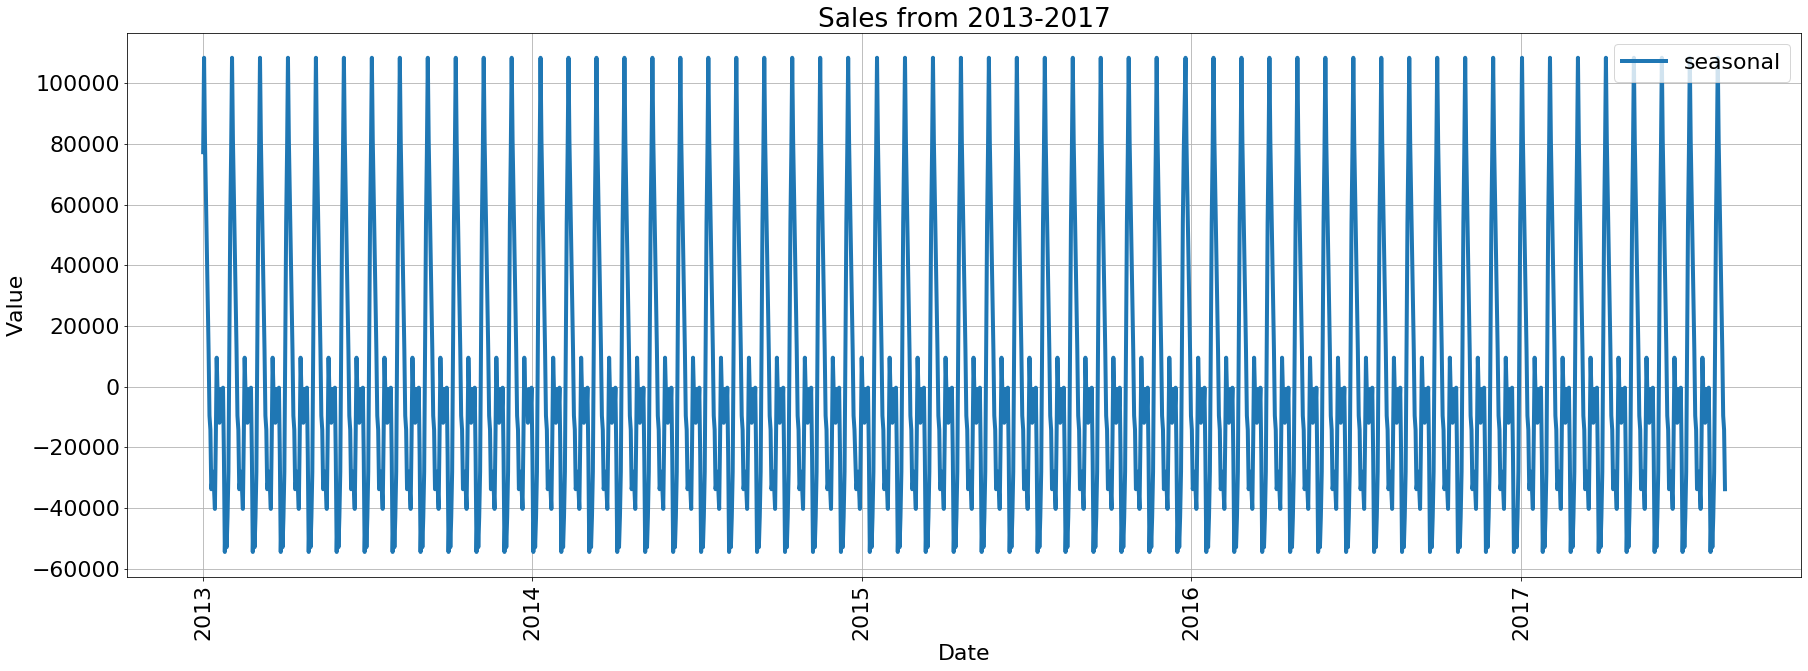

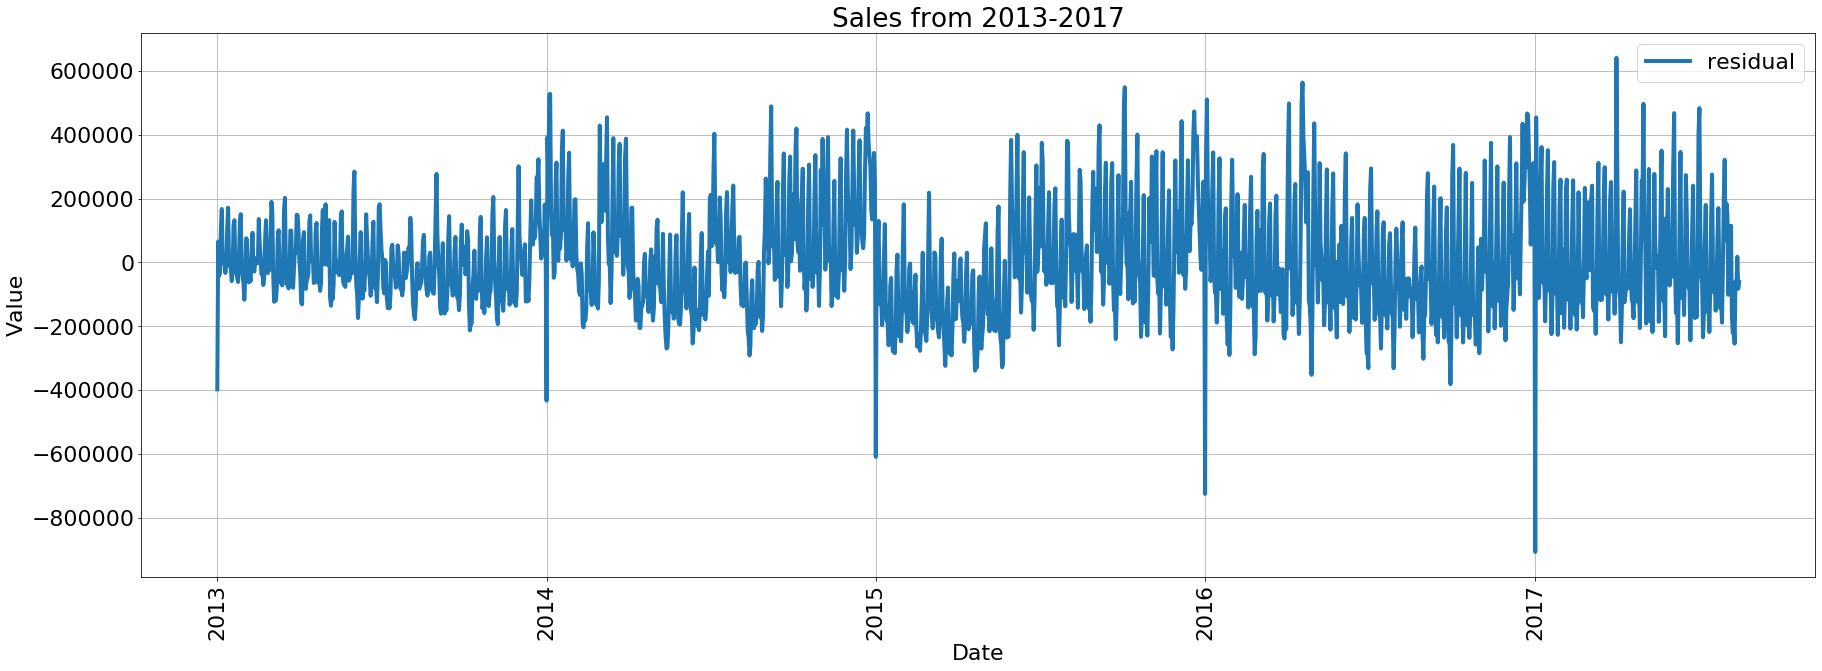

In [25]:
plot_list = ["timeseries", "trend", "seasonal", "residual"]

for column in plot_list:
    main_line_plot(X_index, data[column], "Sales from 2013-2017", "Date", "Value")


# Statsmodels STL Decompose

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose

temp = data.reset_index()
df_stl_month = temp[['index', 'timeseries']].set_index('index')
decomp = seasonal_decompose(df_stl_month.values, period=365)

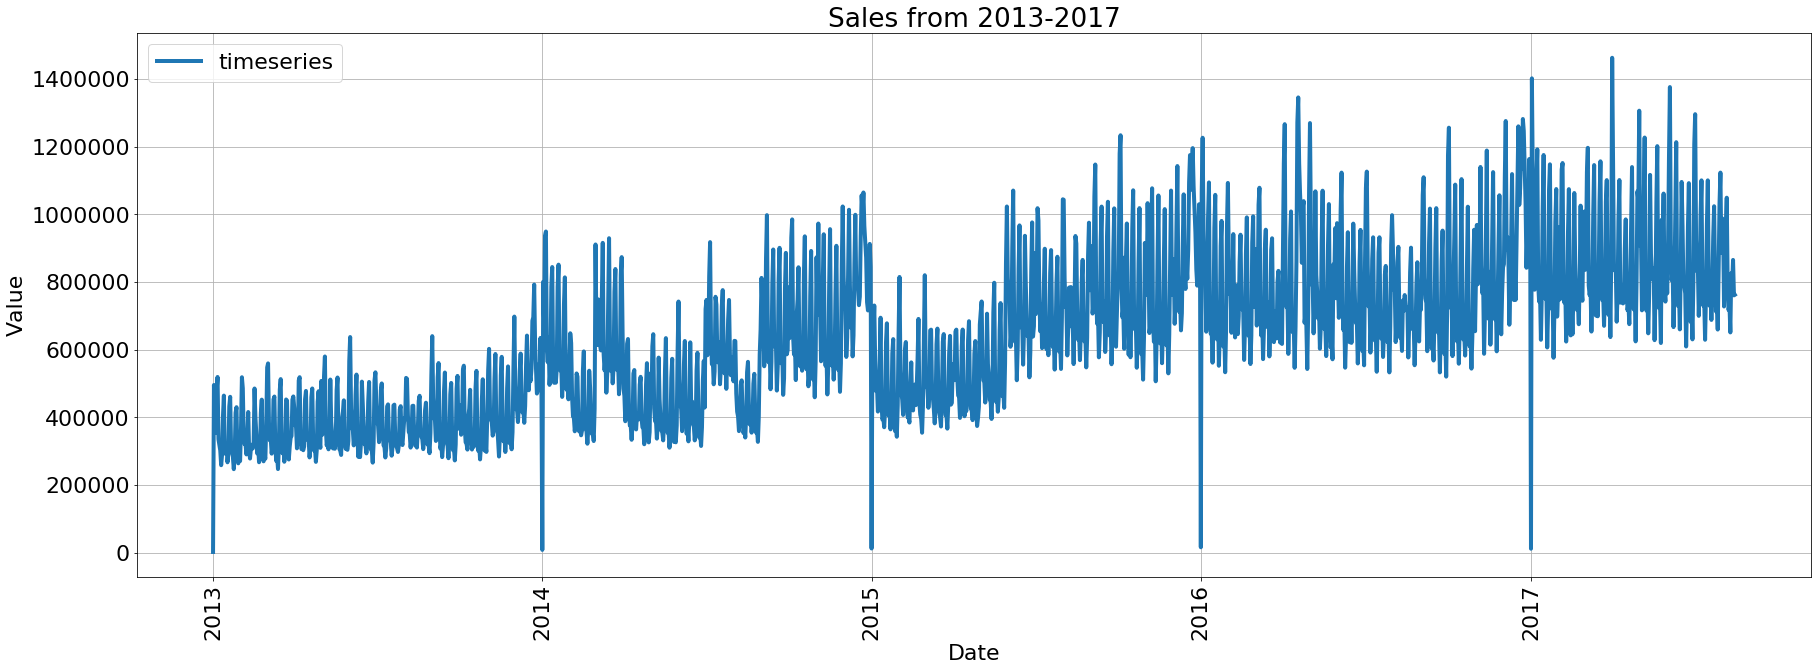

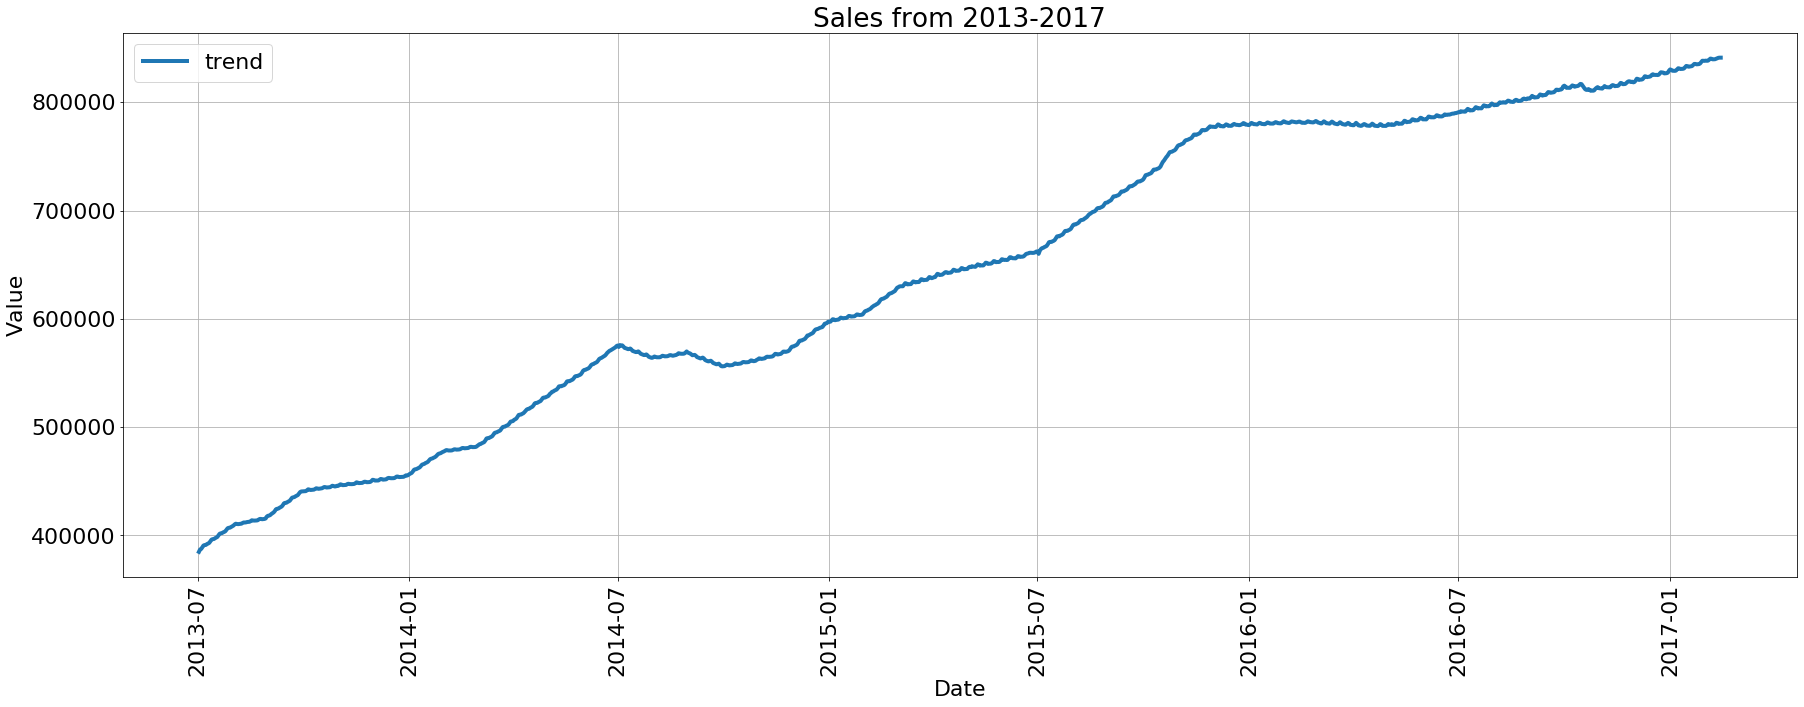

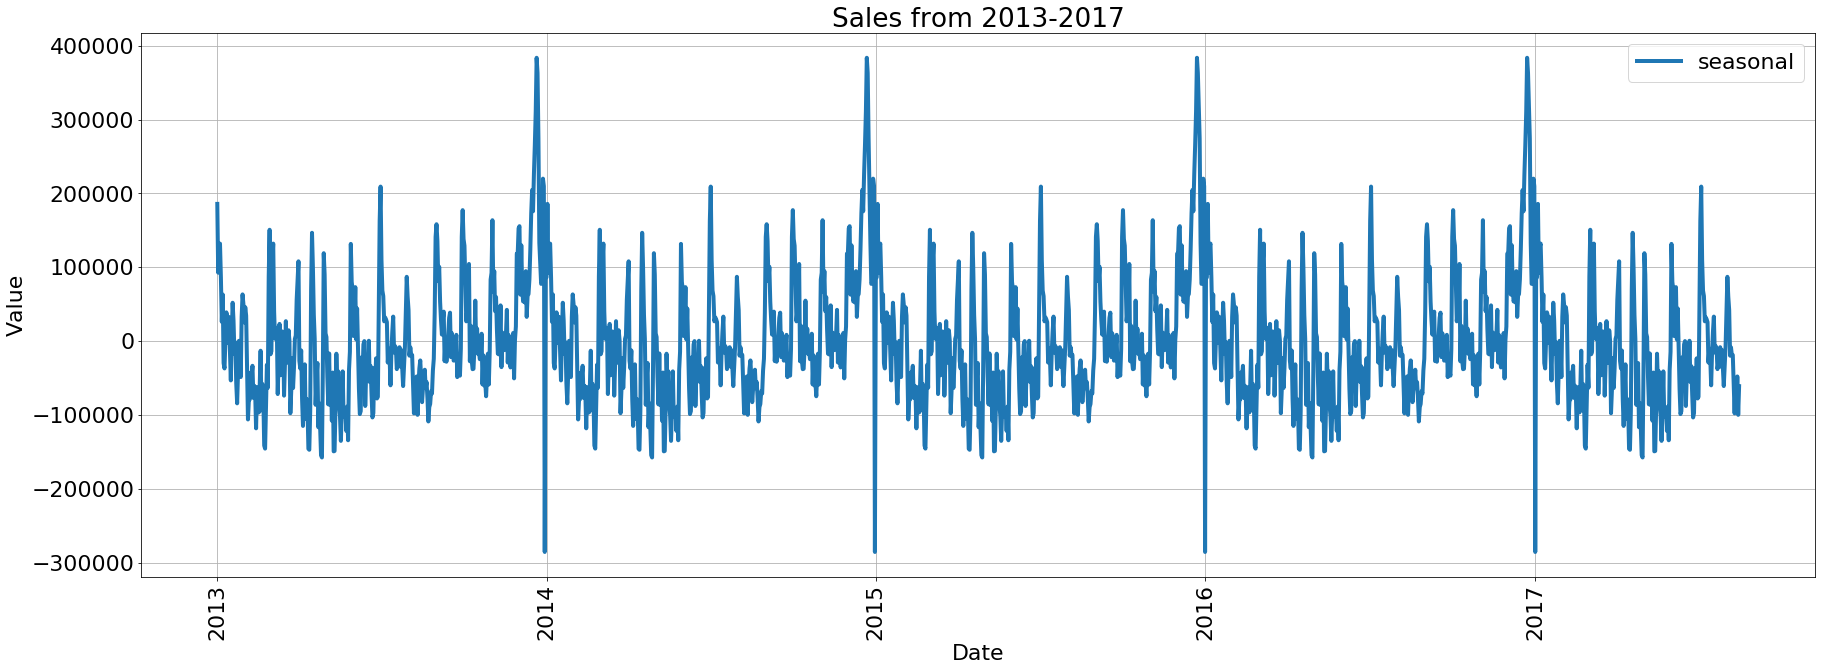

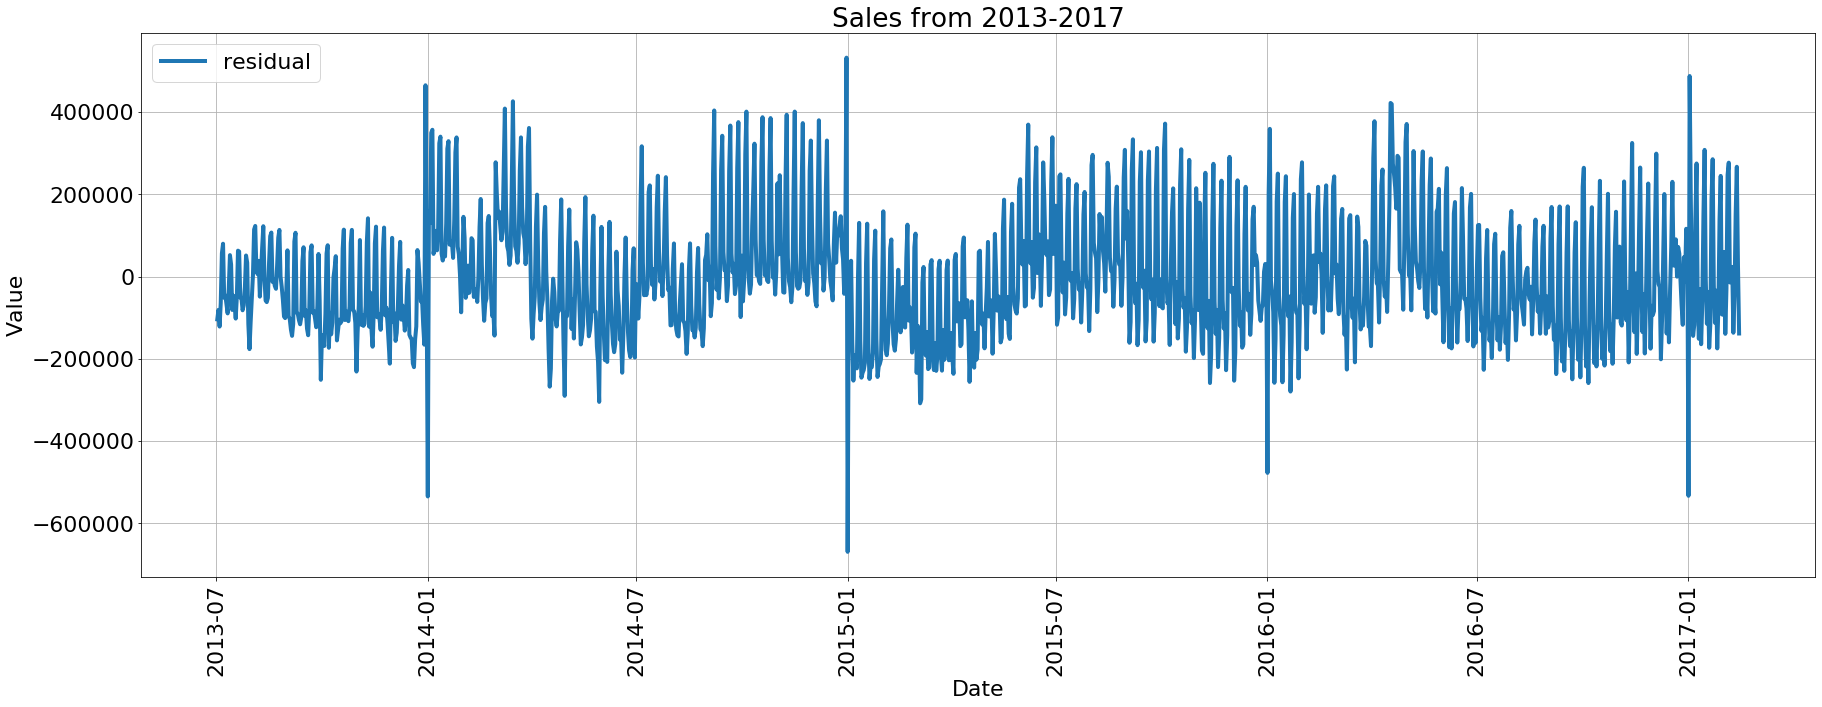

In [50]:
plot_list = ["timeseries", "trend", "seasonal", "residual"]
plot_data = [decomp.observed, decomp.trend, decomp.seasonal, decomp.resid]

for line, name in zip(plot_data, plot_list):
    main_line_plot(X_index, pd.Series(line, name=name), "Sales from 2013-2017", "Date", "Value")


In [28]:
data["rolling_median"] = data["residual"].rolling(30).median()
data["rolling_std"] = data["residual"].rolling(30).std()

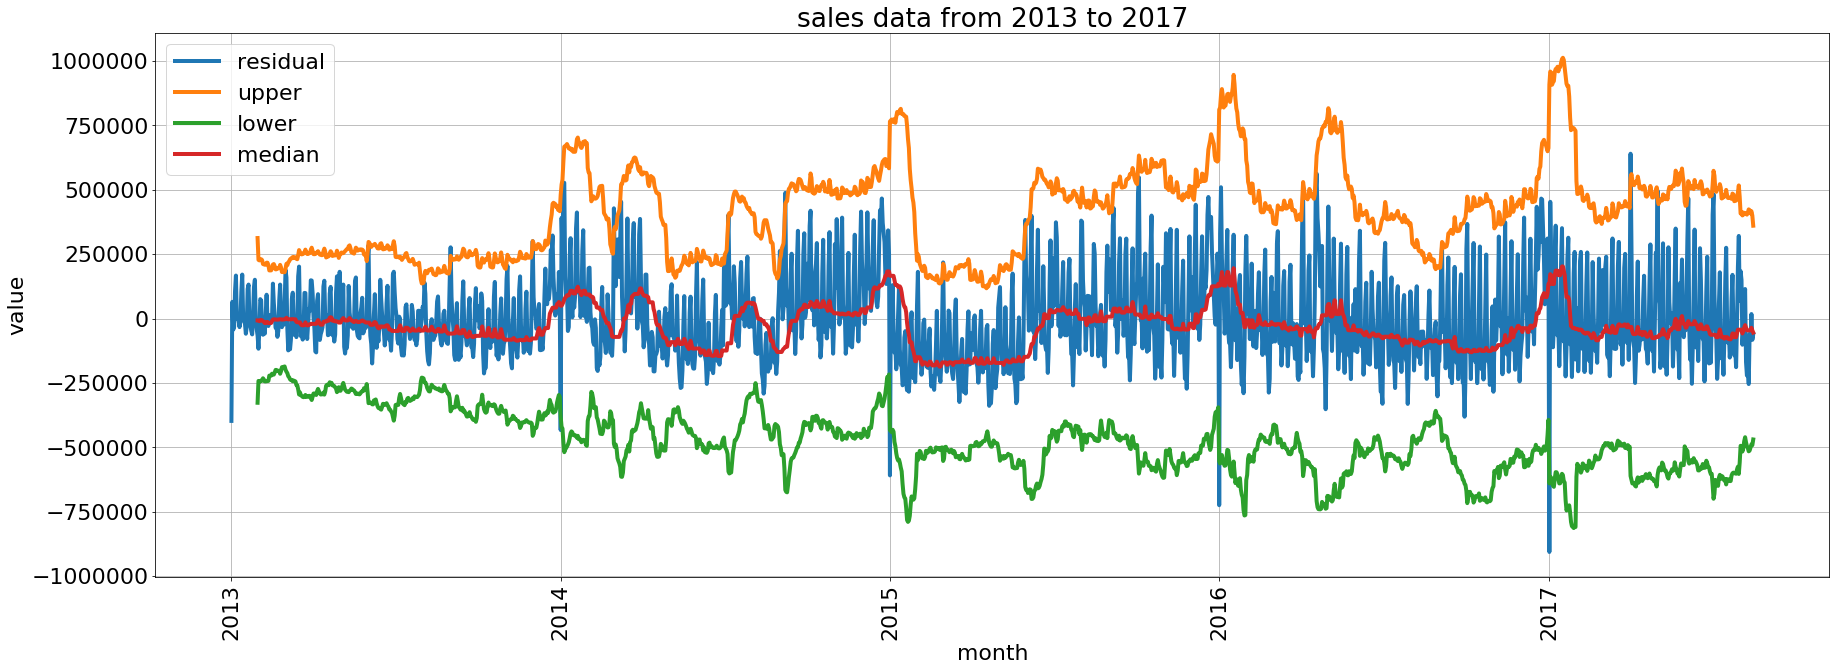

In [29]:
plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(X_index, data.residual, marker='', linestyle='-', label='residual', linewidth=4)
plt.plot(X_index, data.rolling_median + (3 * data["rolling_std"]), marker='', linestyle='-', label='upper', linewidth=4)
plt.plot(X_index, data.rolling_median - (3 * data["rolling_std"]), marker='', linestyle='-', label='lower', linewidth=4)

plt.plot(X_index, data.rolling_median, marker='', linestyle='-', label='median', linewidth=4)

plt.title("sales data from 2013 to 2017")
plt.xlabel("month")
plt.ylabel("value")
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [30]:
cond_list, choice_list = [
    (data.residual > (data.rolling_median + (3 * data["rolling_std"]))), 
    (data.residual < (data.rolling_median - (3 * data["rolling_std"])))], [1, 1]
data["outliers"] = np.select(cond_list, choice_list, default=0)
data["outlier_val"] = np.where(data["outliers"] == 1, data.timeseries, None)


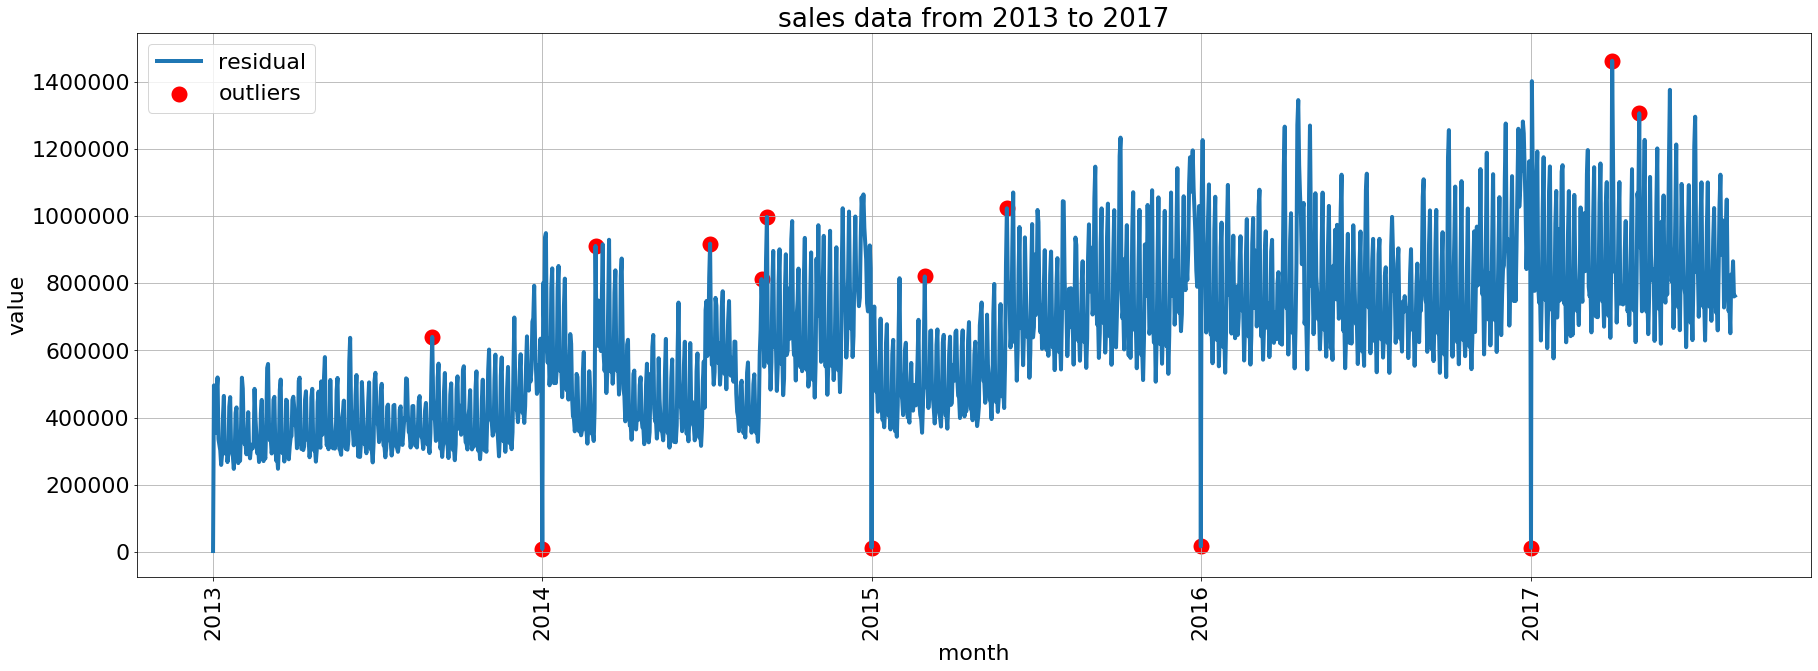

In [31]:
plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(X_index, data.timeseries, marker='', linestyle='-', label='residual', linewidth=4)
plt.scatter(X_index, data.outlier_val, label='outliers', marker="o", color="r", linewidth=10)

plt.title("sales data from 2013 to 2017")
plt.xlabel("month")
plt.ylabel("value")
plt.xticks(rotation=90)
plt.legend()
plt.show()